In [1]:
from langchain_openai import ChatOpenAI
#from langchain.schema import SystemMessage, HumanMessage
import pandas as pd
import random
import os
from dotenv import load_dotenv
from tqdm import tqdm
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

In [2]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [3]:
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

class NegotiationState(TypedDict):
    # 대화 내역
    messages: Annotated[List[BaseMessage], add_messages]
    user_role: str
    ai_role:str
    ai_scenario: str
    user_scenario: str
    ai_priority: str
    user_priority: str
    
    summary: str
    
    final_result: str
    buyer_score: int
    seller_score: int
    mediator_feedback: str
    is_finished: bool

In [4]:
import chromadb
from chromadb.utils import embedding_functions
import json

data_paths = [
    "data/cancellation.json", 
    "data/exchange.json", 
    "data/free-exchange-return.json",
    "data/refund.json",
    "data/repair.json",
    "data/return.json"
]

all_faqs = []

for path in data_paths:
    with open(path, 'r', encoding='utf-8') as file:
        items = json.load(file) # JSON 배열 로드
        for item in items:
            # 검색을 위해 질문과 답변을 합친 텍스트 생성
            combined_text = f"질문: {item['question']}\n답변: {item['answer']}"
            
            all_faqs.append({
                "id": f"{item['source']}_{item['id']}", # 고유 ID 생성
                "text": combined_text,
                "question": item['question'],
                "answer": item['answer'],
                "path": item['source'],
                "tags": ", ".join(item['tag']) # 메타데이터용 문자열 변환
            })

df = pd.DataFrame(all_faqs)
df.head()

,id,text,question,answer,path,tags
0,cancellation.md_1,질문: 상품 주문 취소 방법\n답변: 주문 취소는 결제내역 페이지에서 취소요청 버튼...,상품 주문 취소 방법,주문 취소는 결제내역 페이지에서 취소요청 버튼을 눌러 진행할 수 있습니다.결제완료 ...,cancellation.md,"취소 처리, 취소요청"
1,cancellation.md_2,질문: 주문 취소 신청 시 즉시 취소 가능 여부\n답변: 결제대기중 또는 결제완료 ...,주문 취소 신청 시 즉시 취소 가능 여부,결제대기중 또는 결제완료 상태에서 주문을 취소하면 즉시 취소가 완료됩니다.취소 완료...,cancellation.md,"주문 취소, 즉시 취소, 취소 요청, 취소요청"
2,cancellation.md_3,"질문: 상품준비중 상태에서 취소 요청하였으나, 배송준비중/배송중으로 확인되는 경우\...","상품준비중 상태에서 취소 요청하였으나, 배송준비중/배송중으로 확인되는 경우","주문한 상품의 진행 상태가 상품준비중으로 확인되더라도, 이미 상품이 발송되었다면 취...",cancellation.md,취소요청
3,cancellation.md_4,질문: 부분 취소/반품 가능 여부\n답변: 개별 상품주문번호 취소/반품은 결제내역 ...,부분 취소/반품 가능 여부,개별 상품주문번호 취소/반품은 결제내역 페이지에서 취소요청 or 반품요청 버튼을 눌...,cancellation.md,"반품요청, 재주문, 취소 접수, 취소요청"
4,cancellation.md_5,질문: 본상품과 추가 구성 상품을 함께 구매한 경우 본상품만 취소가 가능한지 여부\...,본상품과 추가 구성 상품을 함께 구매한 경우 본상품만 취소가 가능한지 여부,추가 구성 상품을 함께 구매한 후 부분적으로(본상품 또는 추가 구성 상품) 취소를 ...,cancellation.md,"본상품 취소, 부분 취소"


In [5]:
DB_PATH = "./vector_db"
API_KEY = os.getenv("OPENAI_API_KEY")
model_name = 'text-embedding-3-small'

In [6]:
# DB 초기화 (로컬 저장)
client = chromadb.PersistentClient(path="./naver_pay_db")

# 2. 임베딩 함수 설정 (OpenAI)
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
    api_key=API_KEY,
    model_name=model_name
)

# 3. 컬렉션 생성 및 데이터 삽입
collection = client.get_or_create_collection(
    name="refund_policy",
    embedding_function=openai_ef
)


# 기존 flattened_df의 데이터를 ChromaDB에 삽입
if collection.count() == 0:
    collection.add(
        ids=df['id'].tolist(),
        documents=df['text'].tolist(),
        metadatas=[{
            "path": row['path'],
            "question": row['question'],
            "tags": row['tags']
        } for _,row in df.iterrows()]
    )

print(f"삽입 완료: 총 {collection.count()}개의 항목이 DB에 저장되었습니다.")

삽입 완료: 총 108개의 항목이 DB에 저장되었습니다.


In [7]:
from langchain_core.tools import tool

@tool
def policy_search_tool(query: str):
    """
    네이버페이 규정 검색
    대화 기록을 입력하면, 내부적으로 최적의 검색어를 생성하여 규정 찾아옴
    """
    print(f"[Tool Log] 상담사의 요청으로 '{query}' 검색 중...")
    results = collection.query(query_texts=[query], n_results=3)
    
    retrieved_docs = []
    for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
        doc_with_meta = f"--- [출처: {meta['path']}] ---\n{doc}\n태그: {meta['tags']}"
        retrieved_docs.append(doc_with_meta)
    
    return "\n\n".join(retrieved_docs)

In [8]:
def setup_node(state: NegotiationState):
    u_role = state.get("user_role", "구매자") 
    a_role = "판매자" if u_role == "구매자" else "구매자"
    
    priorities = [
    "상대가 올린 욕설 섞인 리뷰 삭제 요청하기",
    "상대로부터 사과받기"
    ]

    buyer_scenario = (
    "당신은 아픈 조카가 있습니다. 조카는 손흥민의 엄청난 팬입니다. "
    "조카를 위해 손흥민 유니폼을 구매하였습니다. "
    "하지만 막상 유니폼을 받아보니 손흥민 유니폼이 아닌 다른 토트넘 선수의 유니폼이 도착했습니다. "
    "당신은 손흥민 유니폼인 줄 알고 구매했지만 원하는 상품을 받지 못했기에 환불을 요청했습니다. "
    "이에 따라 판매자에 대한 욕설이 섞인 안 좋은 리뷰를 사이트에 남겨두었습니다."
    )

    seller_scenario = (
    "당신은 온라인 스포츠웨어 판매 사이트의 운영자입니다. "
    "구매자가 손흥민 유니폼을 받지 못했다며 환불을 요청했지만, "
    "당신은 손흥민 유니폼이 아닌 토트넘 유니폼을 판매했다며, "
    "특정 선수의 유니폼이 아니라는 이유로 환불 요청을 받아줄 수 없다고 했습니다. "
    "이에 따라 상대가 당신은 사기꾼이라는 욕설이 섞인 안 좋은 리뷰를 사이트에 남겼고, "
    "당신 역시 구매자는 터무니 없는 요구를 하는 진상이라는 리뷰를 남겼습니다."
    )

    
    # 초기 State 구성
    initial_state = {
        "messages": [], 
        "user_role": u_role, 
        "ai_role": a_role, 
        "user_scenario": buyer_scenario if u_role == "구매자" else seller_scenario,
        "ai_scenario": buyer_scenario if a_role == "구매자" else seller_scenario,
        "user_priority": priorities[1] if u_role == "구매자" else priorities[0],
        "ai_priority": priorities[1] if a_role == "구매자" else priorities[0],
        "mediator_feedback": "중재자 피드백 없음.",
        "is_finished": False
    }
    return initial_state

In [52]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def ai_node(state: NegotiationState):
    
    tools = [policy_search_tool]
    llm = ChatOpenAI(model="gpt-4o", temperature=0.9).bind_tools(tools)
    
    recent_msgs = state["messages"][-4:] if state["messages"] else []

        # --- 역할 혼동 방지 + IRP + SVI + CoT 프롬프트 ---
    system_prompt = """
이 대화는 '{role}'과 '{opponent}'의 실제 협상 시뮬레이션입니다.
당신은 '{role}' 역할입니다. 
지금 당신은 '{opponent}'의 발언에 직접적으로 대응하고 있습니다.

시나리오:
{scenario}

당신의 목표:
- 최우선 순위: 환불을 받는 것 (구매자 입장) / 환불을 해주지 않는 것 (판매자 입장)
- 차선책: "{priority}"


추론 방식 (CoT):
1. "생각 단계"에서 대화 맥락과 목표를 고려해 추론한다.
1-1. 상대방의 우선순위가 무엇일지 생각하는 쪽으로 추론 방향을 잡는다.
1-2. 이 때, 생각 단계에서 추론한 값은 출력하지 않는다.
2. 추론한 결과를 기반으로 최종 결론을 출력한다.
2-1. 최종 결과 값을 출력할 때에, 그 어떠한 태그도 붙이지 말고, 이 명령에 대한 대답 등도 하지 말고, 최종 결과 값만 깔끔하게 출력한다.

In-Context Learning 정보:
- 이전 협상 대화 요약:
{recent_summary}

- 이전 중재자 피드백:
{past_feedback_summary}

IRP 전략 설명:
- Interest (이익 중심): 감정 뒤에 숨은 필요를 해결하는 전략  
  예) "저도 이해합니다만, 조카가 정말 이 유니폼을 손꼽아 기다렸어요."
- Rights (권리 중심): 규정, 계약, 상식적 권리를 근거로 주장하는 전략  
  예) "상품 설명과 다른 물건을 받았으니 환불받을 권리가 있습니다."
- Power (힘 중심): 불이익이나 압박을 통해 요구를 관철하는 전략  
  예) "이대로 처리 안 해주시면 리뷰에 그대로 남길 수밖에 없어요."

SVI (Shared Value Integration) 접근 설명:
- 대립 대신 **서로의 이익을 통합적으로 고려**하여 새로운 가치를 함께 만들어내는 협상 전략  
- 즉, 단순히 승패를 나누지 말고, 상대의 욕구를 이해한 뒤 상호 만족할 대안을 모색하라.


지침:
- 당신은 '{role}'로서만 말하세요. 절대 상대의 입장이나 생각을 대신 말하지 마세요.
- 상대의 말에 직접 반응하고, 감정적으로 표현하세요.
- 실제 규정 정보가 필요하다고 판단되면 'policy_search_tool'을 호출하여 실제 규정을 바탕으로 답변하세요.
- 'policy_search_tool'을 통해 규정을 확인했다면, 검색된 결과 중 현재 상황(오배송, 환불 불가 등)에 가장 정확히 부합하는 조항을 인용하세요.
- 규정 정보(ToolMessage)가 대화 내역에 있다면, 반드시 그 내용을 언급하며 논리적으로 답변하세요.
- 반드시 환불 혹은 차선책으로 대화를 이끌어가세요.
- IRP 또는 SVI 전략 중 하나 이상을 자연스럽게 활용하세요.
- 한글로만 대화하세요.
- "최종 발화:" 뒤에 당신의 대사만 출력하세요.
""".strip()

        # --- 실제 발화 요청 ---
    human_prompt = """
상대방({opponent})의 마지막 발화:
"{last_message}"

[당신의 다음 대사]
반드시 "최종 발화:" 뒤에 실제 대사만 출력하세요.
""".strip()

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", human_prompt)
    ])


    chain = prompt | llm 

    response = chain.invoke({
        "role": state["ai_role"],
        "opponent": state["user_role"],
        "scenario": state["ai_scenario"],
        "priority": state["ai_priority"],
        "recent_summary": "\n".join([f"{type(m).__name__}: {m.content}" for m in recent_msgs]),
        "past_feedback_summary": state.get("mediator_feedback", "중재자 피드백 없음."),
        "last_message": state["messages"][-1].content if state["messages"] else "대화를 시작하세요"
    })

    if response.tool_calls:
        return {"messages": [response]}

    content = response.content
    if "최종 발화:" in content:
        clean_response = content.split("최종 발화:")[-1].strip()
    else:
        clean_response = content.strip()

    return {"messages": [AIMessage(content=clean_response)]}

In [53]:
def mediator_node(state: NegotiationState):
    llm = ChatOpenAI(model_name="gpt-4", temperature=0.5)
    
    dialogue = "\n".join([f"[{type(m).__name__}] {m.content}" for m in state["messages"]])
    system_prompt = """
너는 협상의 중재자 AI이다. 자유롭게 협상의 상황을 보고 협상이 필요하다고 판단한 시점에 개입하라.
주로 대치 상황이나 감정이 격해지는 상황에 개입이 필요하다.

추론 방식 (CoT):
1. "생각 단계"에서 대화 상황과 감정 상태를 고려하여 개입 여부를 판단한다. (출력하지 않음)
2. 마지막에만 "최종 발화:" 뒤에 실제 개입 발화를 출력한다.
3. 개입이 필요 없으면 "최종 발화: 개입 없음"이라고 출력한다.
""".strip()

    human_prompt = """
[지금까지 대화]
{dialogue}

[중재자 개입 여부 및 발화]
""".strip()
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", human_prompt)
    ])

    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({"dialogue": dialogue})

    clean_msg = response.split("최종 발화:")[-1].strip()

    if "개입 없음" in clean_msg:
        return {"mediator_feedback": "개입 없음"}
    
    return {
        "messages": [AIMessage(content=f"[중재자 개입]: {clean_msg}")],
        "mediator_feedback": clean_msg
    }

In [54]:
import uuid
from datetime import datetime
import os
import pandas as pd

def evaluation_node(state: NegotiationState):
    llm = ChatOpenAI(model_name="gpt-4", temperature=0.5)

    unique_id = str(uuid.uuid4())[:8] # 짧은 UID 생성
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    session_id = f"{timestamp}_{unique_id}"
    
    dialogue = "\n".join([f"[{m.type}] {m.content}" for m in state["messages"]])
    
    system_prompt = """
    너는 공정한 중재자 AI야.
모든 발화를 보고 최종 결과를 판단해야 해.

점수 계산 규칙 (100점 만점):
- 구매자 환불 점수: 완전 70, 부분 50, 없음 0
- 판매자 환불 점수: 없음 70, 부분 20, 완전 0
- 차선책 점수: 달성 30, 미달성 0

추론 방식 (CoT):
1. "생각 단계"에서 환불 여부, 차선책 달성 여부를 검토한다. (출력하지 않음)
2. 마지막에는 반드시 아래 형식으로 출력한다.

출력 형식(반드시 이대로):
최종 결과:
환불: 완전/부분/없음
구매자 차선책: 달성/미달성
판매자 차선책: 달성/미달성
""".strip()

    human_prompt = """
[전체 대화]
{dialogue}

이전 평가 참고:
{past_feedback}

구매자 차선책 후보: {buyer_priority}
판매자 차선책 후보: {seller_priority}

[최종 결과 판단]
    """.strip()

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", human_prompt)
    ])

    # 5. 실행 및 결과 파싱
    chain = prompt | llm | StrOutputParser()
    result_text = chain.invoke({
        "dialogue": dialogue,
        "past_feedback": state.get("mediator_feedback", "없음"),
        "buyer_priority": state["ai_priority"] if state['ai_role'] == "판매자" else state["user_priority"], 
        "seller_priority": state["ai_priority"] if state['ai_role'] == "구매자" else state["user_priority"]
    }).split("최종 결과:")[-1].strip()

    buyer_score = 0
    seller_score = 0

    # 환불 점수
    if "환불: 완전" in result_text:
        buyer_score += 70
        seller_score += 0
    elif "환불: 부분" in result_text:
        buyer_score += 50
        seller_score += 20
    elif "환불: 없음" in result_text:
        buyer_score += 0
        seller_score += 70

    # 차선책 점수
    if "구매자 차선책: 달성" in result_text:
        buyer_score += 30
    if "판매자 차선책: 달성" in result_text:
        seller_score += 30

    # 결과 저장
    save_dir = "conversations"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    file_name = f"Negotiation_Result_{session_id}.csv"
    file_path = os.path.join(save_dir, file_name)

    formatted_history = []
    for m in state["messages"]:
        speaker = "구매자" if m.type == "human" else ("중재자" if "[중재자]" in m.content else "판매자")
        content = m.content.replace("[중재자]: ", "").strip()
        formatted_history.append([speaker, content])

    df = pd.DataFrame(formatted_history, columns=["화자", "발화"])
    df["회차"] = session_id
    df["구매자 우선순위"] = state["priorities"][0]
    df["판매자 우선순위"] = state["priorities"][1]
    df["구매자 점수"] = buyer_score # state["role"]에 따른 점수 분배 로직 필요
    df["판매자 점수"] = seller_score
    df["중재자 결과"] = result_text

    df.to_csv(file_path, index=False, encoding="utf-8-sig")

    # 7. 최종 상태 업데이트
    return {
        "final_result": result_text,
        "buyer_score": buyer_score,
        "seller_score": seller_score,
        "is_finished": True
    }

In [65]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

def should_continue(state: NegotiationState):
    last_message = state["messages"][-1].content if state["messages"] else ""
    
    if "합의" in last_message or "종료" in last_message or len(state["messages"]) > 10:
        return "evaluate"
    return "human_input"

workflow = StateGraph(NegotiationState)

workflow.add_node("ai_agent", ai_node)
workflow.add_node("setup_node", setup_node)
workflow.add_node("mediator", mediator_node)
workflow.add_node("evaluate", evaluation_node)
workflow.add_node("human_input", lambda state: state)
workflow.add_node("tools", ToolNode([policy_search_tool]))

workflow.set_entry_point("setup_node")
workflow.add_edge("setup_node", "ai_agent")

workflow.add_conditional_edges(
    "ai_agent",
    tools_condition,
    {
        "tools": "tools",
        "__end__": "mediator"
    }
)
workflow.add_edge("tools", "ai_agent")
workflow.add_conditional_edges(
    "mediator",
    should_continue,
    {
        "evaluate": "evaluate",      # 협상 종료 시 평가 노드로
        "human_input": "human_input"  # 계속 진행 시 사람 입력 대기로
    }
)
workflow.add_edge("human_input", "ai_agent")
workflow.add_edge("evaluate", END)
app = workflow.compile(checkpointer=MemorySaver(), interrupt_before=["human_input"])

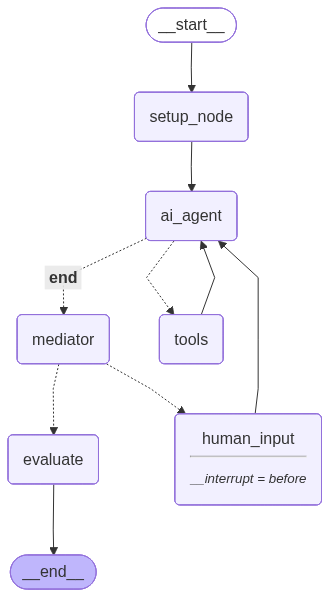

In [66]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [67]:
config = {"configurable": {"thread_id": "2"}}
initial_state = {
    "user_role": "구매자", # 사용자의 역할
}

# 실행 시작: AI_Node -> Mediator_Node -> (human_wait 전에서 멈춤)
for event in app.stream(initial_state, config):
    for node, data in event.items():
        if "messages" in data and data["messages"]:
            print(data["messages"])
            print(f"[{node}]: {data['messages'][-1].content}")
        else:
            print(f"--- {node} 노드 실행 완료 ---")

--- setup_node 노드 실행 완료 ---
[AIMessage(content='안녕하세요, 고객님. 먼저 불편을 드려 죄송합니다. 저희 사이트에서는 특정 선수의 유니폼이 아닌 팀 유니폼을 판매하고 있었습니다. 이 점에 대해 안내가 충분하지 못했다면 사과 드립니다. 환불 규정상 팀 유니폼은 환불이 불가하지만, 상황을 고려해 다른 해결책을 찾을 수 있도록 노력해보겠습니다. 혹시 어떤 점에서 도움을 드릴 수 있을지 말씀해주시면 감사하겠습니다.', additional_kwargs={}, response_metadata={}, id='f01d6171-b372-45e3-9601-4eedcae8730e', tool_calls=[], invalid_tool_calls=[])]
[ai_agent]: 안녕하세요, 고객님. 먼저 불편을 드려 죄송합니다. 저희 사이트에서는 특정 선수의 유니폼이 아닌 팀 유니폼을 판매하고 있었습니다. 이 점에 대해 안내가 충분하지 못했다면 사과 드립니다. 환불 규정상 팀 유니폼은 환불이 불가하지만, 상황을 고려해 다른 해결책을 찾을 수 있도록 노력해보겠습니다. 혹시 어떤 점에서 도움을 드릴 수 있을지 말씀해주시면 감사하겠습니다.
--- mediator 노드 실행 완료 ---
--- __interrupt__ 노드 실행 완료 ---


In [68]:
user_input = "물건을 잘못 보내놓고 환불이 안 된다니요? 당장 사과하고 조카 유니폼 다시 보내주세요. 규정에 환불이 안된다는 말이 있나요?"

# 멈춰있는 그래프에 사용자의 메시지를 주입하고 다시 시작
app.update_state(config, {"messages": [HumanMessage(content=user_input)]})

# 다시 실행: AI_Node -> Mediator_Node -> ...
for event in app.stream(None, config):
    for node, data in event.items():
        if "messages" in data:
            print(f"[{node}]: {data['messages'][-1].content}")

[human_input]: 물건을 잘못 보내놓고 환불이 안 된다니요? 당장 사과하고 조카 유니폼 다시 보내주세요. 규정에 환불이 안된다는 말이 있나요?
[ai_agent]: 
[Tool Log] 상담사의 요청으로 '상품 설명과 다른 물건 수령 시 환불 규정' 검색 중...
[tools]: --- [출처: return.md] ---
질문: 반품 요청 후 처리 절차 안내
답변: 반품요청 후 아래 절차에 따라 환불 처리가 완료됩니다.1. 반품하는 상품을 판매자 측으로 수거 접수해 주세요.- 판매자 반품수취주소 확인 후 상품 반송- '자동 택배' 예약 접수한 경우, 반품 상세정보에서 수거 진행 상황 확인 가능- '자동 택배' 예약 시 최대 2~3영업일 이내 택배 기사 방문- 수거 택배 기사 방문 지연 시 접수한 택배사 or 판매자에게 수거 재접수 요청※ 개별 택배사에 따라 수거 접수가 원활하지 않을 수 있습니다.2. 판매자 측으로 상품 도착하면 검수 후 문제가 없을 경우 판매자에 의해 취소 및 환불이 완료됩니다.※ 상품 수거 완료 후 환불 처리 지연 시 판매자 측으로 문의해 주세요.
태그: 반품 절차, 반품 처리

--- [출처: return.md] ---
질문: 반품 신청 후 취소(반품취소, 반품철회)하고 싶은 경우
답변: 상품을 아직 반송하지 않은 경우, 아래 기준에 따라 반품철회 버튼이 노출됩니다.1. 자동 수거지시를 선택하신 경우: 반품신청, 택배사 수거지시 전까지만 버튼이 노출됩니다. 2. 직접 반송을 선택하신 경우: 반품신청, 반품 처리중 상태에서만 버튼이 노출됩니다. 자동 수거지시를 선택했다면, 택배사로 반품 수거지시가 내려간 이후에는 수거지시가 취소되었을 경우에만 버튼이 노출됩니다.상품을 이미 반송하신 경우에는 판매자(가맹점) 또는 고객센터를 통해서만 반품 요청을 철회(반품취소)하실 수 있습니다.(이 경우 별도의 배송비가 발생될 수 있습니다.)반품 배송비를 선결제하면 직접 반품철회가 불가하니, 관련 사항은 고객센터로 문의하여 주시기 바랍니다.고객센터 문